In [1]:
import gzip
import pickle
import scipy
import numpy as np
import pandas as pd

from scipy import optimize
import matplotlib.pyplot as plt
import matrnn_distributional as dist

In [2]:
plt.rcParams['font.size'] = 8
plt.rcParams["font.family"] = "serif"

In [3]:
jobid = 'matrnn'
d, w = 2, 64

In [4]:
finalstate_fname = 'finalstate_jobid' + str(jobid) + '_d' + str(d) + 'w' + str(w) + '.pkl'

In [5]:
finalstate = pickle.load(gzip.open(finalstate_fname, 'rb'))

In [6]:
mtest = pickle.load(gzip.open('mlocaltest.pkl', 'rb'))

In [7]:
def split(m):
    nobs, nseq, nvar = m.shape
    
    # indices at [1,2] are tte, unc 
    x = m[:, :, np.delete(np.arange(nvar), [1,2])]
    y = m[:, :, :4].reshape((nobs, nseq, 1, 4))
    y[y<0] = 0
    return x, y

In [8]:
xtest, ytest = split(mtest)

## Plot final scales and shapes...

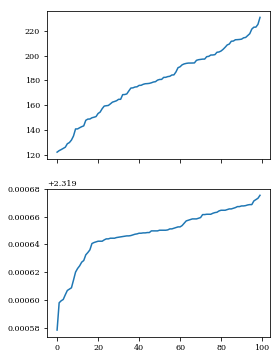

In [9]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(4,6))
ax[0].plot(np.sort(finalstate[:, 0]))
ax[1].plot(np.sort(finalstate[:, 1]))

plt.show()

In [10]:
tse, sc, sh = xtest[:, -1, 0], finalstate[:, 0], finalstate[:, 1]

## Load RUL

In [11]:
rul = pickle.load(gzip.open('rul.pkl', 'rb'))

## Density vs True RUL

In [12]:
dfall = pd.DataFrame({'tse': tse,
                      'sc': sc,
                      'sh': sh,
                      'rul': rul})

In [13]:
dfall = dfall.sort_values('rul')
dfall = dfall.reset_index()

In [14]:
print (dfall.head(5))

   index  rul          sc        sh    tse
0     33  7.0  129.898376  2.319607  203.0
1     67  8.0  128.953445  2.319625  187.0
2     30  8.0  125.196609  2.319609  196.0
3     80  8.0  122.175507  2.319600  213.0
4     81  9.0  140.858322  2.319641  162.0


In [15]:
xvals = dfall['rul']

In [16]:
minx, maxx = .8*min(xvals), 1.2*max(xvals)

In [17]:
print (minx, maxx)

5.6000000000000005 174.0


In [18]:
nxplot = 1000

In [19]:
xvals = np.linspace(minx, maxx, nxplot)

In [20]:
densem = np.zeros((len(dfall), len(xvals)))

In [21]:
idex = 0
for index, row in dfall.iterrows():
    tsetemp = row['tse']
    sctemp = row['sc']
    shtemp = row['sh']
    #print ('tse:', tsetemp, 'sc:', sctemp, 'sh:', shtemp)
    densetemp = np.exp(dist.logdiscrete(tsetemp, xvals, sctemp, shtemp))
    densetemp = densetemp - np.min(densetemp)
    densetemp = densetemp / np.max(densetemp)
    densem[idex,:] = densetemp
    idex += 1

In [22]:
densem.shape

(100, 1000)

In [23]:
densem = densem / np.max(densem)

In [24]:
csfont = {'fontname':'Times New Roman',
          'size': 8}

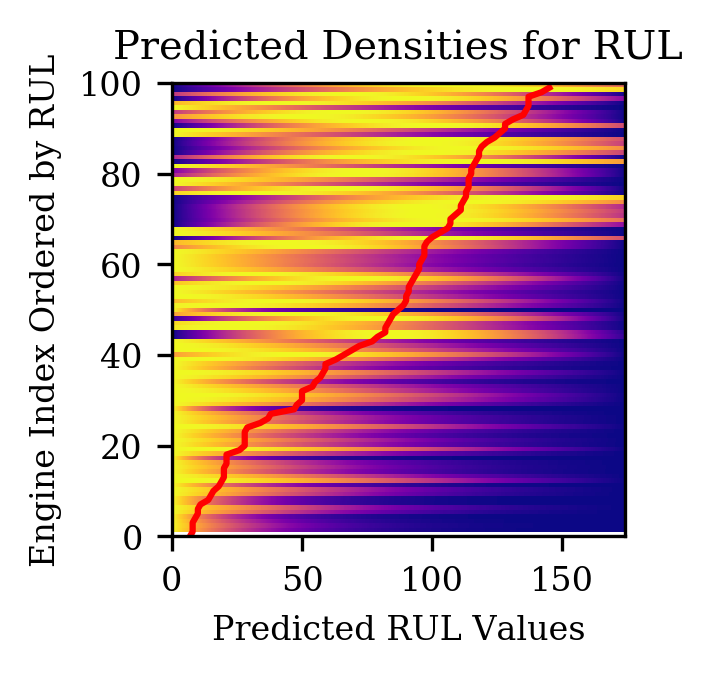

In [25]:
plt.figure(figsize = (2, 2), dpi = 300)

plt.imshow(densem, cmap = 'plasma', 
           origin = 'lower', interpolation = 'none', 
           aspect = maxx/len(dfall), extent = [0, maxx, 1, len(dfall)])
plt.title('Predicted Densities for RUL')
plt.xlabel('Predicted RUL Values')
plt.ylabel('Engine Index Ordered by RUL')
plt.plot(dfall['rul'], np.arange(len(dfall)), color = 'red')
plt.xlim((0, maxx))
plt.ylim((0, len(dfall)))
plt.show()

## Loss Function

In [26]:
def lossfn(d):
    a1, a2 = 13, 10
    return (np.exp(-d/a1)-1)*(d<0)+(np.exp(d/a2)-1)*(d>0)

## Mode as RUL-Est

In [27]:
metric_mode = dist.quantile(tse, .5, sc, sh)

In [28]:
metric_mode[:10]

array([151.98790727, 120.74635366,  54.12558654,  71.54125473,
        74.19492259,  73.95464683,  67.17596921,  46.92953004,
       116.04536638,  49.57466185])

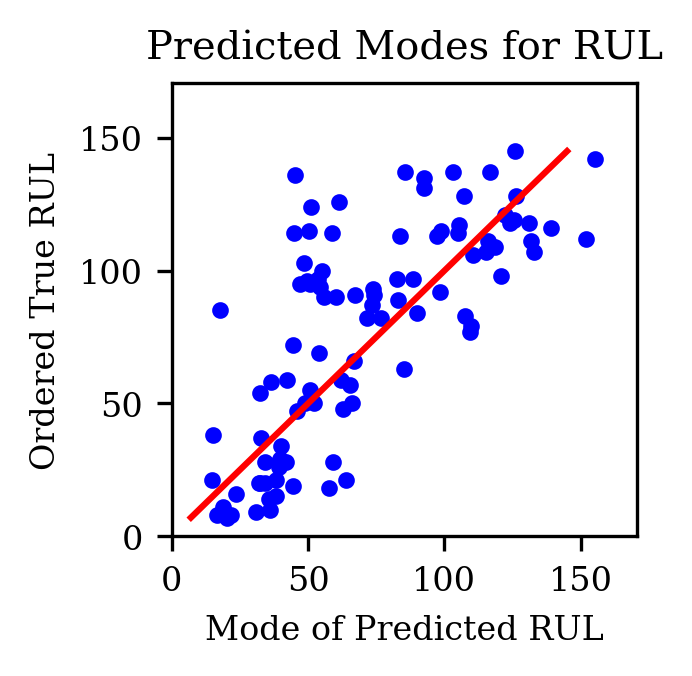

In [29]:
metric = metric_mode

plt.figure(figsize = (2, 2), dpi = 300)
plt.scatter(metric, rul, 
            marker = '.', color = 'b')
xmax = max(metric)
ymax = max(rul)
pltmax = 1.1*max(xmax, ymax)
plt.plot(dfall['rul'], dfall['rul'], color = 'red')

plt.title('Predicted Modes for RUL')
plt.xlabel('Mode of Predicted RUL')
plt.ylabel('Ordered True RUL')
plt.xlim(0, pltmax)
plt.ylim(0, pltmax)

plt.show()

In [30]:
min(metric_mode - rul), max(metric_mode - rul)

(-90.69523214273806, 42.805978653685514)

In [31]:
q = [0, 25, 50, 75, 100]
np.percentile(metric_mode - rul, q)

array([-90.69523214, -21.51768888,   1.03207869,  13.11667058,
        42.80597865])

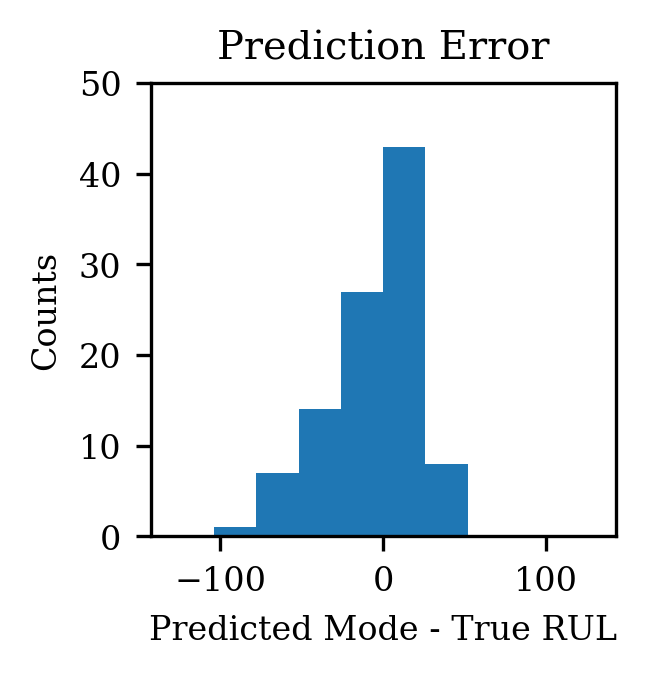

In [46]:
plt.figure(figsize = (2, 2), dpi = 300)
plt.hist(metric_mode - rul, range = (-130, 130))
plt.ylim((0, 50))
plt.title('Prediction Error')
plt.xlabel('Predicted Mode - True RUL')
plt.ylabel('Counts')
plt.show()

In [33]:
mloss = np.average(lossfn(metric_mode - rul))
print ('mloss:', mloss)

mloss: 29.347682729238155


In [34]:
mse = np.average(np.power(metric_mode - rul, 2))
print ('mse:', mse)

mse: 832.8675774842891


In [35]:
rmse = np.sqrt(mse)
print ('rmse:', rmse)

rmse: 28.859445204027903


## Expected Loss Minimizer as RUL-Est

In [36]:
def wbsample(tse, sc, sh, n=1000):
    u = np.random.sample(n)
    return dist.quantile(tse, u, sc, sh)

In [37]:
def loss(x, wbsamplearr):
    d = x-wbsamplearr
    losstemp = lossfn(d)
    return np.average(losstemp)

In [38]:
ntest = xtest.shape[0]
metric_lossmin = np.zeros(ntest)
for i in range(ntest):
    wbsamplearr = wbsample(tse[i], sc[i], sh[i])
    metric_lossmin[i] = optimize.minimize(lambda x: loss(x, wbsamplearr), 1).x

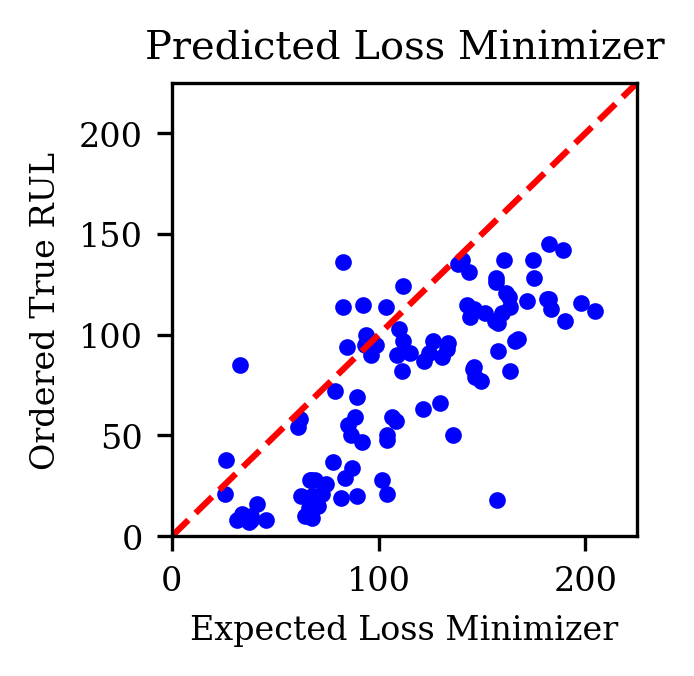

In [39]:
metric = metric_lossmin

plt.figure(figsize = (2, 2), dpi = 300)
plt.scatter(metric, rul, 
            marker = '.', color = 'b')
xmax = max(metric)
ymax = max(rul)
pltmax = 1.1*max(xmax, ymax)
plt.plot([0, pltmax], 
         [0, pltmax], 
         linestyle = '--', color = 'r')

plt.title('Predicted Loss Minimizer')
plt.xlabel('Expected Loss Minimizer')
plt.ylabel('Ordered True RUL')
plt.xlim(0, pltmax)
plt.ylim(0, pltmax)

plt.show()

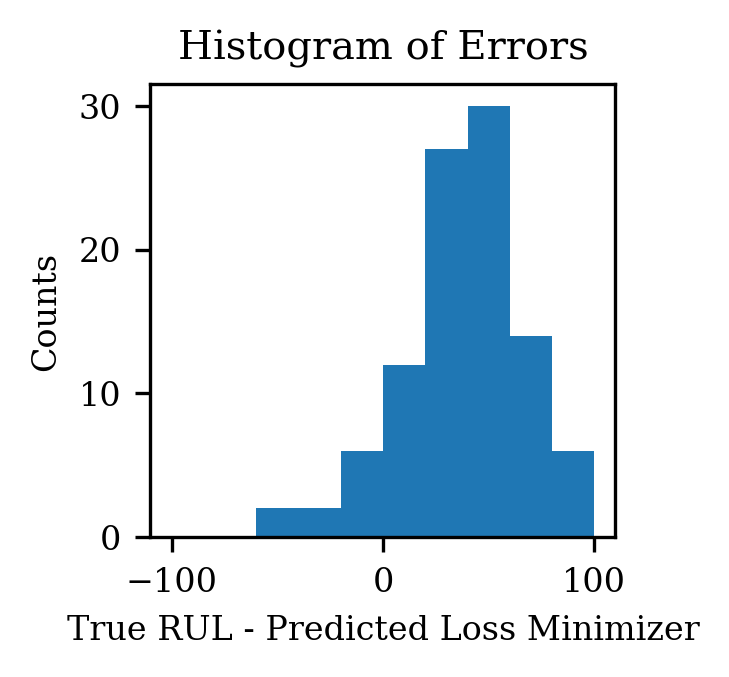

In [40]:
plt.figure(figsize = (2, 2), dpi = 300)
plt.hist(metric_lossmin - rul, range = (-100,100))
plt.title('Histogram of Errors')
plt.xlabel('True RUL - Predicted Loss Minimizer')
plt.ylabel('Counts')
plt.show()

In [41]:
mloss = np.average(lossfn(metric_lossmin - rul))
print ('mloss:', mloss)

mloss: 12003.315377300605


In [42]:
mse = np.average(np.power(metric_lossmin - rul, 2))
print ('mse:', mse)

mse: 2340.8008255474033


In [43]:
rmse = np.sqrt(mse)
print ('rmse:', rmse)

rmse: 48.381823297054474
